1: Import Necessary Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, SimpleRNN
from tensorflow.keras.utils import to_categorical
import shap
import lime
import lime.lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import joblib

e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2: Data Preparation

In [2]:
# Load the dataset
data = pd.read_csv('../../src/data/creditcard_processed_data.csv')

# Verify the column names in the dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Transaction_Hour', 'Transaction_DayOfWeek'],
      dtype='object')


In [3]:
# Convert the Time column to numerical values
data['Time'] = pd.to_datetime(data['Time'])  # Convert to datetime
data['Time'] = data['Time'].astype(int) / 10**9  # Convert to timestamp in seconds

# Feature and Target Separation
X = data.drop(columns=['Class'])
y = data['Class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the class distribution before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Display the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_train_smote).value_counts())

Class distribution before SMOTE:
Class
0    226597
1       383
Name: count, dtype: int64
Class distribution after SMOTE:
Class
0    226597
1    226597
Name: count, dtype: int64


3: Model Training

Traditional Machine Learning Models

In [4]:
# Initialize and train the models
lr_model = LogisticRegression(max_iter=1000, solver='sag', random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
mlp_model = MLPClassifier(random_state=42)

# Train the models
lr_model.fit(X_train_smote, y_train_smote)
dt_model.fit(X_train_smote, y_train_smote)
rf_model.fit(X_train_smote, y_train_smote)
gb_model.fit(X_train_smote, y_train_smote)
mlp_model.fit(X_train_smote, y_train_smote)

e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


MLPClassifier(random_state=42)

Neural Network Models

In [5]:
# Build the CNN model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_smote.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_model.fit(X_train_smote.values.reshape(-1, X_train_smote.shape[1], 1), to_categorical(y_train_smote), epochs=10, batch_size=32, validation_data=(X_test.values.reshape(-1, X_test.shape[1], 1), to_categorical(y_test)))

# Build the RNN model
rnn_model = Sequential([
    SimpleRNN(64, input_shape=(X_train_smote.shape[1], 1), activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
rnn_model.fit(X_train_smote.values.reshape(-1, X_train_smote.shape[1], 1), to_categorical(y_train_smote), epochs=10, batch_size=32, validation_data=(X_test.values.reshape(-1, X_test.shape[1], 1), to_categorical(y_test)))

# Build the LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(X_train_smote.shape[1], 1), activation='relu'),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
lstm_model.fit(X_train_smote.values.reshape(-1, X_train_smote.shape[1], 1), to_categorical(y_train_smote), epochs=10, batch_size=32, validation_data=(X_test.values.reshape(-1, X_test.shape[1], 1), to_categorical(y_test)))

e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 108s 5ms/step - accuracy: 0.9211 - loss: 18.1607 - val_accuracy: 0.9752 - val_loss: 0.0782
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.9833 - loss: 0.0564 - val_accuracy: 0.9946 - val_loss: 0.0196
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.9920 - loss: 0.0243 - val_accuracy: 0.9927 - val_loss: 0.0223
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.9917 - val_loss: 0.0256
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 0.9972 - loss: 0.0104 - val_accuracy: 0.9956 - val_loss: 0.0178
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 72s 5ms/step - accuracy: 0.9979 - loss: 0.0081 - val_accuracy: 0.9968 - val_loss: 0.0170
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 70s 5ms/step - accuracy: 0.9982 - loss: 0.0072 - val_accuracy: 0.9954 - val_loss: 0.0281
Epoch 8/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy

e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 103s 7ms/step - accuracy: 0.9248 - loss: 0.1872 - val_accuracy: 0.9829 - val_loss: 0.0507
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 97s 7ms/step - accuracy: 0.9841 - loss: 0.0451 - val_accuracy: 0.9738 - val_loss: 0.0805
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - accuracy: 0.9916 - loss: 0.0252 - val_accuracy: 0.9918 - val_loss: 0.0240
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 100s 7ms/step - accuracy: 0.9926 - loss: 0.0228 - val_accuracy: 0.9922 - val_loss: 0.0230
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 100s 7ms/step - accuracy: 0.9741 - loss: 0.0666 - val_accuracy: 0.9864 - val_loss: 0.0391
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 100s 7ms/step - accuracy: 0.9345 - loss: 0.1908 - val_accuracy: 0.8807 - val_loss: 0.3066
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 100s 7ms/step - accuracy: 0.9368 - loss: 0.1617 - val_accuracy: 0.9828 - val_loss: 0.0473
Epoch 8/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - acc

4: Model Evaluation

In [6]:
# Import necessary libraries for evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Define the models to be evaluated
models = {
    "Logistic Regression": lr_model,
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Multi-Layer Perceptron": mlp_model
}

evaluation_results = []

# Evaluate traditional machine learning models
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    evaluation_results.append({
        "Model": model_name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Accuracy": accuracy
    })

# Evaluate neural network models
nn_models = {
    "CNN": cnn_model,
    "RNN": rnn_model,
    "LSTM": lstm_model
}

for model_name, model in nn_models.items():
    y_pred_prob = model.predict(X_test.values.reshape(-1, X_test.shape[1], 1))
    y_pred = np.argmax(y_pred_prob, axis=1)
    report = classification_report(y_test, y_pred, output_dict=True)
    accuracy = accuracy_score(y_test, y_pred)
    evaluation_results.append({
        "Model": model_name,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"],
        "Accuracy": accuracy
    })

# Create DataFrame for evaluation results
evaluation_df = pd.DataFrame(evaluation_results)

# Display the combined evaluation results in tabular form
print("\nEvaluation Results for All Models:")
print(evaluation_df.to_string(index=False))

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\OnlineClass\AIM\Fraud_Detection_ML_Model_in_E-commerce_and_Credit_Card_Transactions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in


Evaluation Results for All Models:
                 Model  Precision   Recall  F1-Score  Accuracy
   Logistic Regression   0.998445 0.996687  0.997410  0.996687
         Decision Tree   0.998567 0.997744  0.998078  0.997744
         Random Forest   0.999581 0.999595  0.999576  0.999595
     Gradient Boosting   0.998454 0.993180  0.995445  0.993180
Multi-Layer Perceptron   0.998323 0.980580  0.988809  0.980580
                   CNN   0.998754 0.997797  0.998166  0.997797
                   RNN   0.998393 0.992493  0.995060  0.992493
                  LSTM   0.996830 0.998414  0.997622  0.998414


5. Model Explainability

5.1 Using SHAP

SHAP Summary Plot

<Figure size 1000x600 with 0 Axes>

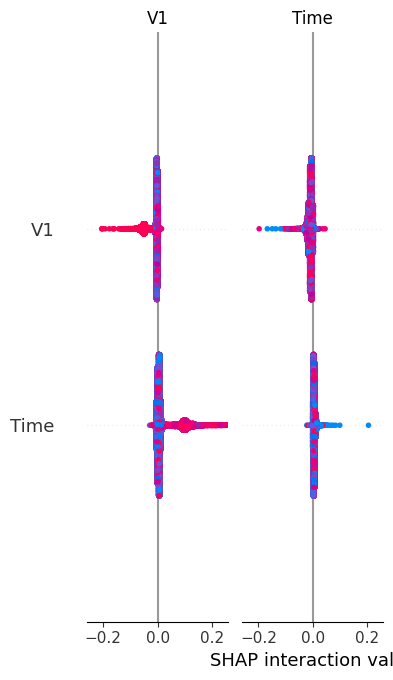

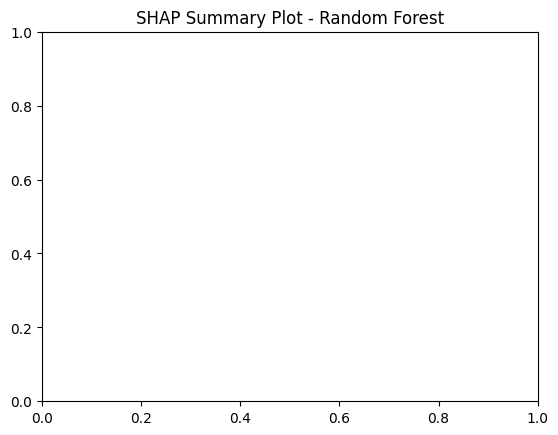

In [10]:
# Initialize SHAP explainer for Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test, check_additivity=False)

# SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_rf, X_test)
plt.title('SHAP Summary Plot - Random Forest')
plt.show()

SHAP Force Plot for a single prediction

In [ ]:
# Initialize SHAP explainer for Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test, check_additivity=False)

# SHAP Force Plot for a single prediction
shap.initjs()
plt.figure(figsize=(10, 6))

# Extracting shap values for the first instance
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][0], X_test.iloc[0, :], matplotlib=True)
plt.title('SHAP Force Plot (Single Prediction) - Random Forest')
plt.show()

SHAP Dependence Plot for all features

In [ ]:
# Initialize SHAP explainer for Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test, check_additivity=False)

# Number of features to plot
num_features = len(X_test.columns)
num_rows = (num_features // 3) + 1  # Adjust the number of rows for the grid

# Create a figure for the combined SHAP Dependence Plots
fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot SHAP Dependence Plots for all features
for i, feature in enumerate(X_test.columns):
    shap.dependence_plot(feature, shap_values_rf, X_test, show=False, ax=axes[i])
    axes[i].set_title(f'SHAP Dependence Plot - Feature: {feature}')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

5.2: Using LIME

In [ ]:
# Initialize LIME explainer for Random Forest model
lime_explainer = LimeTabularExplainer(X_train_smote.values, feature_names=X_train_smote.columns, class_names=['Non-Fraud', 'Fraud'], mode='classification')

# Explain a prediction for Random Forest
exp_rf = lime_explainer.explain_instance(X_test.iloc[0].values, rf_model.predict_proba, num_features=len(X_test.columns))

# Number of features to plot
num_features = len(X_test.columns)
num_rows = (num_features // 3) + 1  # Adjust the number of rows for the grid

# Create a figure for the combined LIME Feature Importance Plots
fig, axes = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot LIME Feature Importance for each feature using text and bar chart data
for i, (feature, weight) in enumerate(exp_rf.as_list()):
    axes[i].barh([feature], [weight], color='b')
    axes[i].set_title(f'LIME Feature Importance - {feature}')
    axes[i].set_xlim(left=min([x[1] for x in exp_rf.as_list()]) - 0.1, right=max([x[1] for x in exp_rf.as_list()]) + 0.1)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

6: Feature Importance

In [ ]:
# Calculate feature importances from the Random Forest model
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title('Feature Importances from Random Forest')
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Display the feature importances
print("Feature Importances:")
print(feature_importance_df)